# Recurrent Neural Network - Predict Future Price of Tesla stock

In [1]:
import json
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, explained_variance_score

from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
%matplotlib inline

In [3]:
plt.style.use(['bmh', 'seaborn-talk'])

## Data

In [4]:
df = pd.read_csv('TSLA.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)
df.head()

,open,high,low,close,volume
2010-06-29,19.00,25.0000,17.54,23.89,18766300
2010-06-30,25.79,30.4192,23.30,23.83,17187100
2010-07-01,25.00,25.9200,20.27,21.96,8218800
2010-07-02,23.00,23.1000,18.71,19.20,5139800
2010-07-06,20.00,20.0000,15.83,16.11,6866900


Time range of the data

In [5]:
df.index.min(), df.index.max()

(Timestamp('2010-06-29 00:00:00'), Timestamp('2020-05-01 00:00:00'))

## Exploratory Data Analysis

In [6]:
plot_data = df.copy()

Text(0.5, 1.0, 'High - Low')

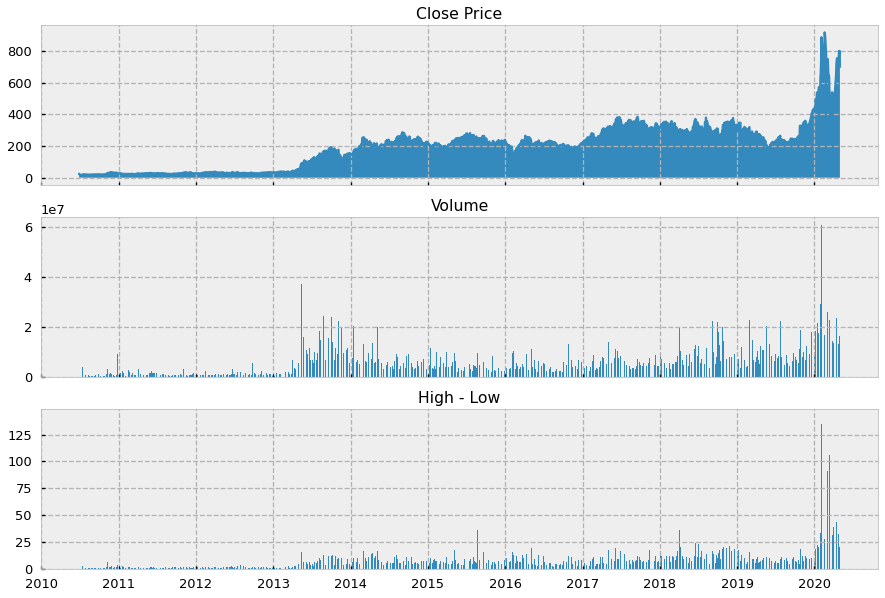

In [7]:
plot_data['intradayflux'] = plot_data.eval('high - low')
fig, ax  = plt.subplots(3,1, figsize=(15,10), sharex=True)
ax[0].plot(plot_data.close)
ax[0].fill_between(plot_data.index, plot_data.close)
ax[0].set_title('Close Price')
ax[1].bar(x=plot_data.index, height=plot_data.volume)
ax[1].set_title('Volume')
ax[2].bar(x=plot_data.index, height=plot_data.intradayflux)
ax[2].set_title('High - Low')

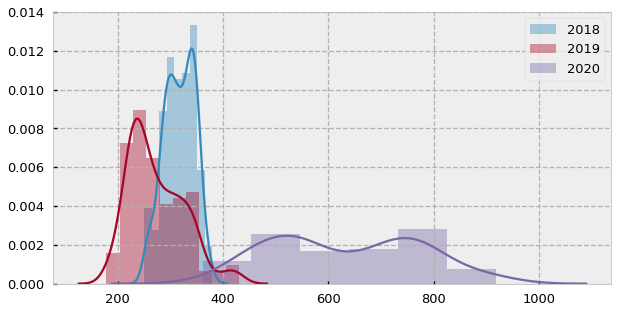

In [8]:
plot_data = df.copy()
plot_data['year'] = plot_data.index.year
plt.figure(figsize=(10, 5))
for i in range(2018,2021,1):
    sns.distplot(plot_data[plot_data.year==i].close.values, label=i)
plt.legend()

## Prepare the data

In [9]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

Training data will be all data prior to 02/012019. Validation data will between 02/01/2019 and before 02/01/2020. Testing data will be all data in 2020

In [10]:
train_index = int(np.where(df.index=='2019-01-02')[0])

In [11]:
valid_index = int(np.where(df.index=='2020-01-02')[0])

Scale the data

In [12]:
scale = MinMaxScaler()

In [13]:
scale.fit(df.iloc[:train_index]) # only fit on the training data

MinMaxScaler(copy=True, feature_range=(0, 1))

In [14]:
scaled_data = scale.transform(df)

Look at the data from the last 20 days to predict the price 5 days into the future

In [15]:
X_train, y_train = multivariate_data(
    dataset=scaled_data,
    target=scaled_data[:,3],
    start_index=0,
    end_index=train_index,
    history_size=20,
    target_size=5,
    step=1,
    single_step=True
)

In [16]:
X_valid, y_valid = multivariate_data(
    dataset=scaled_data,
    target=scaled_data[:,3],
    start_index=train_index,
    end_index=valid_index,
    history_size=20,
    target_size=5,
    step=1,
    single_step=True
)

In [17]:
X_test, y_test = multivariate_data(
    dataset=scaled_data,
    target=scaled_data[:,3],
    start_index=valid_index,
    end_index=None,
    history_size=20,
    target_size=5,
    step=1,
    single_step=True
)

## Train and Evaluate Model

### Base Model

In [21]:
early_stop = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=25
)

In [22]:
model = Sequential()

model.add(LSTM(5, input_shape=X_train.shape[1:], return_sequences=False))
model.add(BatchNormalization())

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [23]:
model.fit(
    X_train, 
    y_train, 
    batch_size=32, 
    epochs=600, 
    validation_data=(X_valid, y_valid),
    callbacks=[early_stop],
    verbose=1
)

Train on 2122 samples, validate on 232 samples
Epoch 1/600
2122/2122 [==============================] - 5s 2ms/sample - loss: 0.3981 - val_loss: 0.3285
Epoch 2/600
2122/2122 [==============================] - 1s 462us/sample - loss: 0.0379 - val_loss: 0.2127
Epoch 3/600
2122/2122 [==============================] - 1s 486us/sample - loss: 0.0139 - val_loss: 0.1673
Epoch 4/600
2122/2122 [==============================] - 1s 435us/sample - loss: 0.0093 - val_loss: 0.1435 loss: 0
Epoch 5/600
2122/2122 [==============================] - 1s 509us/sample - loss: 0.0085 - val_loss: 0.1148
Epoch 6/600
2122/2122 [==============================] - 1s 485us/sample - loss: 0.0065 - val_loss: 0.0773
Epoch 7/600
2122/2122 [==============================] - 1s 533us/sample - loss: 0.0064 - val_loss: 0.0493
Epoch 8/600
2122/2122 [==============================] - 1s 444us/sample - loss: 0.0062 - val_loss: 0.0247
Epoch 9/600
2122/2122 [==============================] - 1s 433us/sample - loss: 0.0064 - v

(0.0, 0.06)

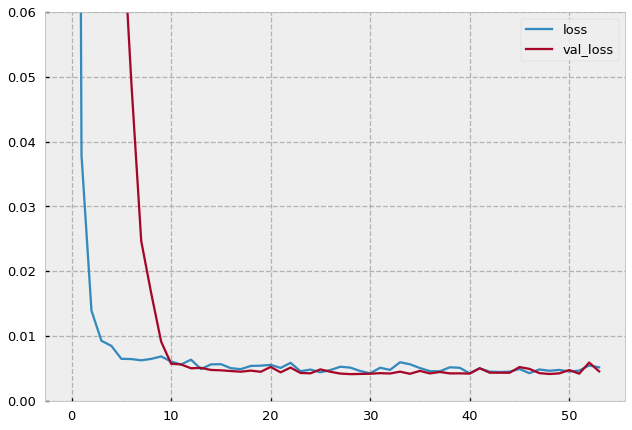

In [24]:
loss = pd.DataFrame(model.history.history)
loss.plot()
plt.ylim([0,0.06])

Root Mean Squared Error

In [25]:
rmse = np.sqrt(scale.inverse_transform(np.array([[0,0,0,loss['val_loss'].min(),0]])))[0,3]
rmse

4.161002580470915

In [26]:
perc_error = rmse/df['close'].iloc[train_index:valid_index].mean()
round(perc_error*100,2)

1.52

Explained Variance

In [27]:
round(explained_variance_score(y_valid, model.predict(X_valid))*100,2)

83.49

### Using Keras Tuner for Hyper Parameter Optimization

I used Keras Tuner to run multiple variations of the above model with different number of layers and etc. I only ran for 100 different variations.

In [19]:
results = glob.glob('tuning_results/*/trial.json')

tuning = []
for result in results:
    with open(result) as f:
        j = json.load(f)
    temp = {}
    temp['id'] = j['trial_id']
    temp['score'] = j['score']
    temp['hyperparameters'] = j['hyperparameters']['values']
    tuning.append(temp)
                    

tuning_df = pd.DataFrame(tuning)

Top 5 Models

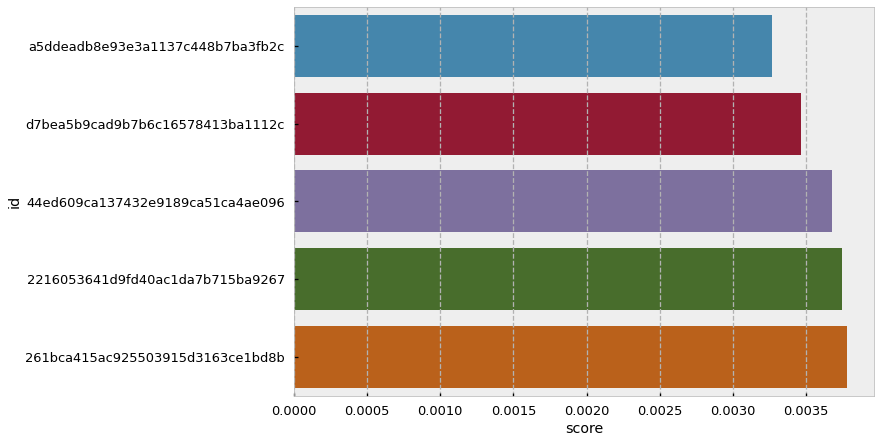

In [20]:
sns.barplot(y='id', x='score', data=tuning_df.sort_values(by='score').iloc[:5])

The HyperParameters of the best model as well as results. As you can see form the RMSE and % error aren't that much better

In [28]:
tuning_df.iloc[tuning_df.score.idxmin()]['hyperparameters']

{'n_ltsm_layers': 0,
 'final_ltsm_units': 90,
 'final_ltsm_dropout': 0.30000000000000004,
 'n_RNN_dense_layers': 1,
 'layer_0_units': 250,
 'layer_0_dropout': 0.4,
 'dense_layer_0_units': 38,
 'dense_layer_0_dropout': 0.0,
 'layer_1_units': 254,
 'layer_1_dropout': 0.2,
 'dense_layer_1_units': 130,
 'dense_layer_1_dropout': 0.30000000000000004}

In [30]:
rmse = np.sqrt(scale.inverse_transform([[0,0,0,tuning_df.iloc[tuning_df.score.idxmin()]['score'],0]])[0,3])
rmse

4.123790315954028

In [32]:
perc_error = rmse/df['close'].iloc[train_index:valid_index].mean()
round(perc_error*100,2)

1.51

## Test the Model 

How does the model perfom on completely new data

In [35]:
new_model = Sequential()

new_model.add(LSTM(90, input_shape=X_train.shape[1:], return_sequences=False))
new_model.add(Dropout(0.3))
new_model.add(BatchNormalization())

new_model.add(Dense(38, activation='relu'))

new_model.add(Dense(1))

new_model.compile(optimizer='adam', loss='mse')

In [36]:
new_model.fit(
    X_train, 
    y_train, 
    batch_size=32, 
    epochs=600, 
    validation_data=(X_valid, y_valid),
    callbacks=[early_stop],
    verbose=1
)

Train on 2122 samples, validate on 232 samples
Epoch 1/600
2122/2122 [==============================] - 5s 3ms/sample - loss: 0.1369 - val_loss: 0.3292
Epoch 2/600
2122/2122 [==============================] - 1s 613us/sample - loss: 0.0417 - val_loss: 0.2997
Epoch 3/600
2122/2122 [==============================] - 1s 637us/sample - loss: 0.0272 - val_loss: 0.2794
Epoch 4/600
2122/2122 [==============================] - 1s 572us/sample - loss: 0.0225 - val_loss: 0.2398
Epoch 5/600
2122/2122 [==============================] - 1s 612us/sample - loss: 0.0185 - val_loss: 0.2168
Epoch 6/600
2122/2122 [==============================] - 1s 641us/sample - loss: 0.0127 - val_loss: 0.1711
Epoch 7/600
2122/2122 [==============================] - 1s 623us/sample - loss: 0.0116 - val_loss: 0.1587
Epoch 8/600
2122/2122 [==============================] - 1s 604us/sample - loss: 0.0108 - val_loss: 0.1206
Epoch 9/600
2122/2122 [==============================] - 1s 642us/sample - loss: 0.0093 - val_loss:

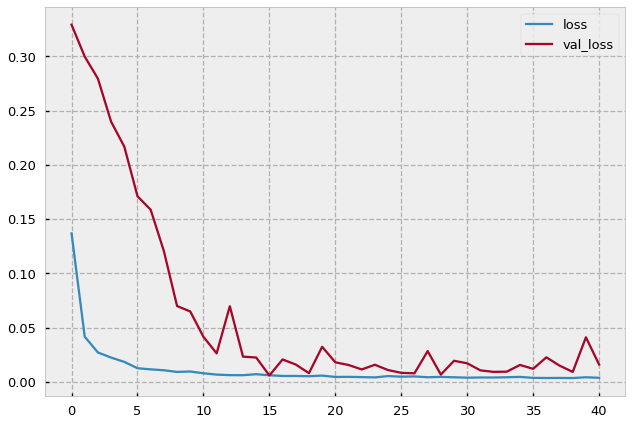

In [37]:
loss = pd.DataFrame(new_model.history.history)
loss.plot()

In [38]:
y_pred = new_model.predict(X_test)

In [39]:
rmse = np.sqrt(scale.inverse_transform([[0,0,0,mean_squared_error(y_test, y_pred.reshape(59,)),0]])[0,3])
rmse

10.023811741069846

In [40]:
perc_error = rmse / df['close'].iloc[valid_index:].mean()
round(perc_error*100,2)

1.58

In [41]:
valid = df['close'][train_index:valid_index+25].reset_index(drop=True)

actual = df['close'][valid_index+25:].reset_index(drop=True)
actual.index = actual.index + valid.index.max() + 1

pred = pd.Series(
    scale.inverse_transform(np.hstack((np.zeros((y_pred.shape[0], 3)),y_pred,np.zeros((y_pred.shape[0], 1)))))[:,3]
)
pred.index = pred.index + valid.index.max() + 1

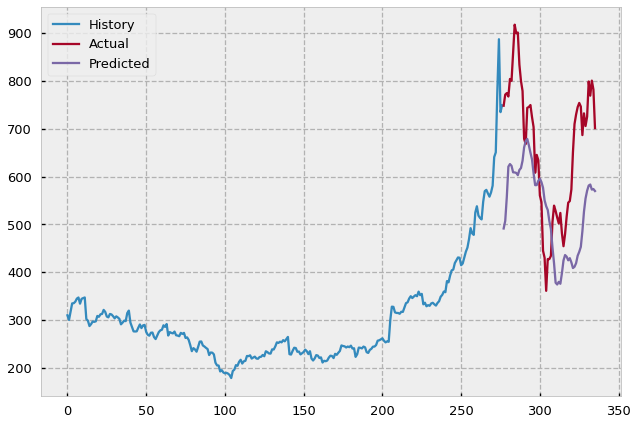

In [42]:
plt.plot(valid, label='History')
plt.plot(actual, label='Actual')
plt.plot(pred, label='Predicted')
plt.legend()

## END